# <span style="color:black;">EVI Phenology</span>


***Developed by Uilson Aires***

## <span style="color:black;">Extract pixel values from raster</span>


Extracting raster values for a specific geographic coordinate is very useful to obtain surface information. It can provide data for several applications, such as environmental monitoring, water resource management, agriculture, urban planning, and more. In this tutorial, we will learn how to use Python to obtain and plot a timeseries of [enhanced vegetation index (EVI)](https://bikeshbade.com.np/tutorials/Detail/?title=All%20you%20need%20to%20know%20about%20EVI&code=21) for a specific longitude and latitude coordinate. The following libraries will be required for this tutorial:

In [60]:
# Import libraries
import os
import glob
import pyproj
import rasterio
import numpy as np
import matplotlib.pyplot as plt


Now we need to read the EVI files, which you can [download](https://github.com/uvaires/extract_pixels_values/tree/gh-pages) and save them in your machine. Please make sure you change the directory in the code where the images are located. The EVI where calculate from [harmonizes landsat sentinel (HLS)](https://search.earthdata.nasa.gov/search/granules?p=C2021957657-LPCLOUD&pg[0][v]=f&pg[0][gsk]=-start_date&q=HLS%20v2.0&tl=1690213798!3!!) product for tile T15SYT located in the north region of Mississippi State, US.

In [61]:
# Input directory
dir_input = r'C:\tutorial'
# Read the images
evi_img = glob.glob(os.path.join(dir_input,'**', 'evi*.tif'), recursive=True)
print(evi_img)

['C:\\tutorial\\evi_clip\\evi_2022-03-31.tif', 'C:\\tutorial\\evi_clip\\evi_2022-04-10.tif', 'C:\\tutorial\\evi_clip\\evi_2022-04-14.tif', 'C:\\tutorial\\evi_clip\\evi_2022-04-15.tif', 'C:\\tutorial\\evi_clip\\evi_2022-04-22.tif', 'C:\\tutorial\\evi_clip\\evi_2022-06-19.tif', 'C:\\tutorial\\evi_clip\\evi_2022-06-24.tif', 'C:\\tutorial\\evi_clip\\evi_2022-06-25.tif', 'C:\\tutorial\\evi_clip\\evi_2022-06-29.tif', 'C:\\tutorial\\evi_clip\\evi_2022-09-12.tif', 'C:\\tutorial\\evi_clip\\evi_2022-09-13.tif', 'C:\\tutorial\\evi_clip\\evi_2022-09-21.tif', 'C:\\tutorial\\evi_clip\\evi_2022-09-22.tif', 'C:\\tutorial\\evi_clip\\evi_2022-09-27.tif', 'C:\\tutorial\\evi_clip\\evi_2022-09-29.tif', 'C:\\tutorial\\evi_clip\\evi_2022-10-02.tif', 'C:\\tutorial\\evi_clip\\evi_2022-10-15.tif', 'C:\\tutorial\\evi_clip\\evi_2022-10-17.tif', 'C:\\tutorial\\evi_clip\\evi_2022-10-27.tif']


To extract the pixel information from several rasters, we have to combine multiple raster layers into a single multi-band raster. This can be useful for various tasks, such as creating RGB images from separate Red, Green, and Blue bands, stacking time-series data, or combining different data sources into a single dataset.

In [62]:
# Create an empty list to store the loaded layers
evi_layers = []
# Loop through the EVI images and load them
for evi_path in evi_img:
    with rasterio.open(evi_path) as src:
        evi_layer = src.read(1)
        evi_layers.append(evi_layer)

# Stack the EVI layers using np.dstack
stacked_evi = np.dstack(evi_layers)
stacked_evi.shape

(160, 186, 19)

Now we can specify a latitude and longitude coordinate of an interest region in [World Geodetic System (WGS84)](https://gisgeography.com/wgs84-world-geodetic-system/), which will be used to extract evi timeseries.

In [63]:
# Specified latitude and longitude
lat, lon = 33.537373878071, -90.362358867976

As the coordinates are in WGS84, we need to convert them for the same coordinates of our input images, which are in [Universal Transverse Mercator (UTM)](https://www.usgs.gov/faqs/what-does-term-utm-mean-utm-better-or-more-accurate-latitudelongitude). UTM coordinates are expressed in metric units (meters), which are more suitable for precise measurements, calculations, and spatial analysis compared to degrees in geographic coordinates. Metric units are particularly advantageous when calculating distances, areas, and other spatial measurements.

In [64]:
# Function to convert the coordinates of the images
def reproject_coords(input_raster, lon, lat):
    # Open the input raster to obtain its coordinate reference system (CRS)
    with rasterio.open(input_raster[0]) as src:
        proj = src.crs.to_epsg()  # Get the EPSG code of the raster's CRS

    # Define the original coordinate reference system as WGS 84 (EPSG:4326)
    original_proj = pyproj.CRS("EPSG:4326")

    # Create the target coordinate reference system based on the EPSG code of the raster's CRS
    target_proj = pyproj.CRS("EPSG:" + str(proj))

    # Create a transformer object for coordinate transformation
    transformer = pyproj.Transformer.from_crs(original_proj, target_proj, always_xy=True)

    # Use the transformer to convert the input latitude and longitude to UTM coordinates
    lon_utm, lat_utm = transformer.transform(lon, lat)

    # Return the UTM easting (X) and northing (Y) coordinates
    return lon_utm, lat_utm

In [65]:
# Reproject the coordinates from WG84 to UTM
coords_preproj = reproject_coords(evi_img, lon, lat)
print(coords_preproj)

(744926.9121044673, 3713978.869997402)


To extrac the pixel values to our lat and long is necessary to convert the geographic coordinates to pixel coordinates within a raster. Raster datasets are structured as grids of pixels, where each pixel represents a specific area on the Earth's surface. To work with raster data effectively, it's essential to align your geographic coordinates (latitude and longitude) with the grid of the raster.

In [66]:
# Open the first EVI raster to obtain its CRS and transform
with rasterio.open(evi_img[0]) as src:
    crs = src.crs
    transform = src.transform

# Transform latitude and longitude to pixel coordinates (row and column)
col, row = ~transform *(coords_preproj[0], coords_preproj[1])
# Extract the EVI time series at the specified pixel location
evi_values = stacked_evi[int(row), int(col),:]
print(evi_values)

[0.10460394 0.11798723 0.13999657 0.10465156 0.15005945 0.22576557
 0.2339059  0.29257447 0.29473507 0.5715145  0.6149399  0.51590955
 0.38220865 0.2742439  0.30013332 0.2250008  0.15824258 0.12402089
 0.12401063]


Before plotting the EVI values, we will obtain the date of each raster. As we do not have the metadata of the images, let's use the OS library to extract the date from the image titles.

In [67]:
evi_dates = []
# Extract dates from the filenames and add them to the list
for dates in evi_img:
    date = os.path.basename(dates).split('_')[1].split('.')[0]
    evi_dates.append(date)

print(evi_dates)

['2022-03-31', '2022-04-10', '2022-04-14', '2022-04-15', '2022-04-22', '2022-06-19', '2022-06-24', '2022-06-25', '2022-06-29', '2022-09-12', '2022-09-13', '2022-09-21', '2022-09-22', '2022-09-27', '2022-09-29', '2022-10-02', '2022-10-15', '2022-10-17', '2022-10-27']


Now we can plot the EVI timeseries:

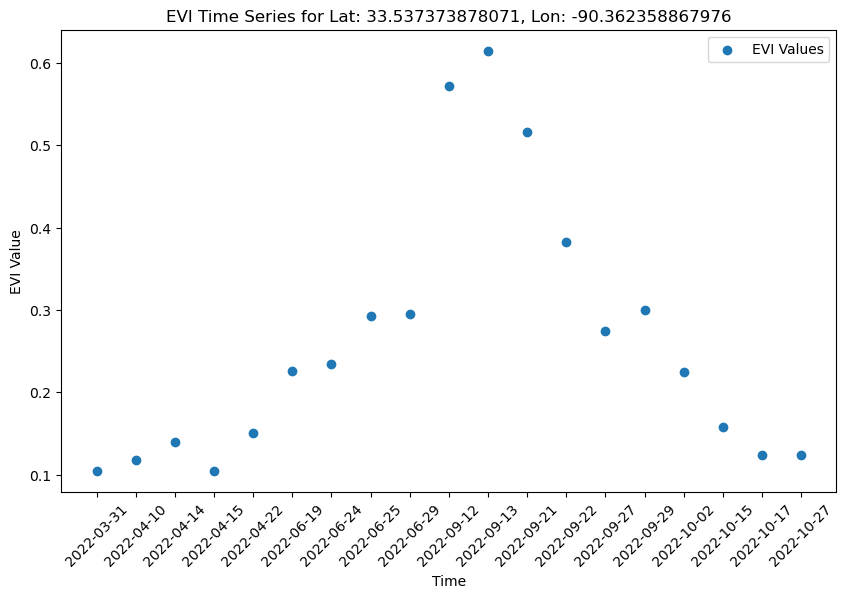

In [68]:
# Plot the complete EVI time series
plt.scatter(evi_dates, evi_values, label='EVI Values')
plt.title(f'EVI Time Series for Lat: {lat}, Lon: {lon}')
plt.xlabel('Time')
plt.ylabel('EVI Value')
plt.xticks(rotation=45)
plt.legend()
# Set the size
fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.show()


We can notice a characteristic pattern in the EVI plot, often observed in areas with seasonal vegetation cycles. This pattern can be explained by the natural growth and senescence of vegetation over the course of a year. In agriculture, the behavior of EVI for an annual crop reflects the different stages of its growth and development throughout the growing season. Monitoring EVI over time can provide valuable information about crop health, phenological stages, and yield potential. This information is essential for agricultural management decisions, such as timing planting and harvesting operations and assessing crop stress or disease.